In [0]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense
from tensorflow.keras.layers import Lambda, Dot
from tensorflow.keras.regularizers import l2

# Rating environment

In [0]:
N_FEATURES = 10
N_USERS = 20
N_MOVIES = 100
MAX_USERS = 300
MAX_MOVIES = 1000

# https://www.desmos.com/calculator/ftbdppvm03

## Helper functions

In [0]:
def generate_data(n_samples, n_features, rng=np.random.default_rng(), scheme="gauss", n_means=10, means_pol=5, pol=5, pol_threshold=1e-5):
    if scheme == "gauss":
        means = 2 * np.random.random((n_means, n_features)) - 1
        old_norms = np.linalg.norm(means, axis=1)
        for i in range(len(means)):
            means[i] = np.sign(means[i]) * np.abs(means[i]) ** means_pol
            means[i][np.abs(means[i]) < pol_threshold] = 0
        new_norms = np.linalg.norm(means, axis=1)
        for i in range(len(means)):
            means[i] *= old_norms[i] / new_norms[i]
        data = np.zeros((n_samples, n_features))
        batch_size = n_samples // n_means
        for i in range(n_means):
            data[batch_size*i:batch_size*(i+1)] = rng.multivariate_normal(means[i], np.identity(n_features)/n_features, batch_size)
        return means, data

    elif scheme == "polarized":
        data = 2 * rng.random((n_samples, n_features)) - 1
        for i in range(len(data)):
            polarization = rng.choice(pol-2) + 2
            data[i] = np.sign(data[i]) * np.abs(data[i]) ** polarization
            data[i][np.abs(data[i]) < pol_threshold] = 0
        return data
    else:
        raise ValueError("unknown scheme")

def cosine_similarity(user, movie):
    return np.dot(user, movie) / (np.linalg.norm(user) * np.linalg.norm(movie))

def reward_func(user, movie):
    """return cosine similarity somewhat polarized, then scaled and shifted between 0 and 5"""
    x = cosine_similarity(user, movie)
    if x == -1:
        return -1
    x = 0.5 * (x + 1)
    x = 1 / (1 + (((1-x)/x)**1.5))
    return x * 2 - 1

def get_rewards_matrix(users, movies, reward_f=reward_func):
    n_users, n_movies = len(users), len(movies)
    res = np.zeros((n_users, n_movies))
    for i in range(n_users):
        for j in range(n_movies):
            res[i][j] = reward_f(users[i], movies[j])
    return res

def get_seen_matrix(n_users, n_movies, history):
    res = np.zeros((n_users, n_movies))
    for user_idx, movie_idx in history:
        res[user_idx][movie_idx] = 1
    return res

In [0]:
# means, movies = generate_data(50, 10, rng=np.random.default_rng(), scheme="gauss", n_means=5, means_pol=5, pol=20, pol_threshold=1e-5)
# users = generate_data(10, 10, rng=np.random.default_rng(), scheme="polarized", n_means=2, means_pol=5, pol=20, pol_threshold=1e-5)

In [0]:
# np.array([[reward_func(m, u) for m in means] for u in users])

## Environment

In [0]:
class Environment:
    
    def __init__(self, 
                 n_features=N_FEATURES, 
                 max_users=MAX_USERS,
                 max_movies=MAX_MOVIES,
                 n_users=N_USERS, 
                 n_movies=N_MOVIES,
                 history=None, 
                 reward_f=reward_func, 
                 context_size=10,
                 a=0.05,
                 b=0.025,
                 c=3,
                 d=0,
                 quit_prob_init=0.05,
                 subscription_rate=20,
                 movie_change_rate=1,
                 remove_movie_definitely=False,
                 seed=None):
      
        self.reset(n_features=n_features, max_users=max_users, 
                   max_movies=max_movies, n_users=n_users, n_movies=n_movies, 
                   history=history, reward_f=reward_f, 
                   context_size=context_size, a=a, b=b, c=c, d=d, 
                   quit_prob_init=quit_prob_init, 
                   subscription_rate=subscription_rate, 
                   movie_change_rate=movie_change_rate, 
                   remove_movie_definitely=remove_movie_definitely,
                   seed=seed)
        
    def reset(self, n_features=N_FEATURES, max_users=MAX_USERS, 
              max_movies=MAX_MOVIES, n_users=N_USERS, n_movies=N_MOVIES, 
              history=None, reward_f=reward_func, context_size=10, 
              a=0.05, b=0.025, c=3, d=0, quit_prob_init=0.05, 
              subscription_rate=20, movie_change_rate=1,
              remove_movie_definitely=False, seed=None):
        
        self.n_features = n_features
        self.max_users = max_users
        self.max_movies = max_movies
        self.n_users = n_users
        self.optimal_users = n_users
        self.n_movies = n_movies
        self.context_size = context_size
        self.quit_prob_init = quit_prob_init
        self.subscription_rate = subscription_rate
        self.rng = np.random.default_rng(seed)
        self.movie_change_rate = movie_change_rate
        self.remove_movie_definitely = remove_movie_definitely

        self.users = generate_data(max_users, n_features, self.rng, scheme="polarized")
        self.means, self.movies = generate_data(max_movies, n_features, self.rng, scheme="gauss")
        self.movies_with_noise = self.movies + self.rng.normal(0, 0.01, self.movies.shape)
        self.rewards_matrix = get_rewards_matrix(self.users, self.movies, reward_f)
        self.status_users = np.zeros(max_users)
        self.status_movies = np.zeros(max_movies)
        self.quit_probabilities = np.zeros(max_users) + quit_prob_init
        self.init_status()

        self.get_update_prob_coeff = lambda x : -a / (1 + np.exp(-(c*x-d))) + b
        self.history = [] if history is None else history
        self.seen_matrix = get_seen_matrix(self.max_users, self.max_movies, self.history)
        self.step_count_tracker = 0
    
    def add_movie(self, movie_idx=None):
        if movie_idx is None:
            not_airing = np.nonzero(self.status_movies == 0)[0]
            n = len(not_airing)
            if n > 0:
                self.status_movies[not_airing[self.rng.choice(n)]] = 1
        else:
            assert self.status_movies[movie_idx] == 0, "trying to add a movie which is already airing"
            self.status_movies[movie_idx] = 1
        self.n_movies += 1

    def add_user(self, user_idx=None):
        if user_idx is None:
            not_subscribed = np.nonzero(self.status_users == 0)[0]
            n = len(not_subscribed)
            if n > 0:
                user_idx = not_subscribed[self.rng.choice(n)]
                self.status_users[user_idx] = 1
                self.quit_probabilities[user_idx] = self.quit_prob_init
        else:
            assert self.status_users[user_idx] == 0, "trying to add a user which is already subscribed"
            self.status_users[user_idx] = 1
            self.quit_probabilities[user_idx] = self.quit_prob_init
        self.n_users += 1
        self.optimal_users += 1

    def get_best_movie(self, user_idx, context):
        """for implicit feedback training"""
        rewards = [self.rewards_matrix[user_idx][m_idx] for m_idx in context]
        best_movie = context[np.argmax(rewards)]
        return best_movie

    def get_reward(self, user_idx, movie_idx, context, should_update=True):
        """returns a binary reward"""
        
        reward = self.rewards_matrix[user_idx][movie_idx]
        
        # keep best choice consequences for regret computations
        best_reward = np.max([self.rewards_matrix[user_idx][m_idx] for m_idx in context])
        optimal_quit_prob = self.quit_probabilities[user_idx] + self.get_update_prob_coeff(best_reward)
        optimal_quit_prob = max(0, min(1, optimal_quit_prob))
        if should_update:
            self.optimal_users -= optimal_quit_prob
            self.update_probability(user_idx, reward)
            self.update_quit(user_idx)

        self.update_history(user_idx, movie_idx, reward, best_reward, self.n_users, self.optimal_users, context)

        return 1 if reward > 0 else -1
    
    def get_next_step(self, should_update=True):
        self.step_count_tracker += 1
        if self.step_count_tracker % self.movie_change_rate == 0:
            env.add_movie()
            env.remove_movie(definitely=self.remove_movie_definitely)
        if should_update and self.step_count_tracker % self.subscription_rate == 0:
            self.add_user()
        subscribed_users = np.nonzero(self.status_users == 1)[0]
        if len(subscribed_users) == 0:
            return -2, None
        else:
            user_permutation = self.rng.permutation(subscribed_users)
            for user_idx in user_permutation:  # try until you can suggest a movie to a user
                seen_movies = np.nonzero(self.seen_matrix[user_idx])[0]
                airing_movies = np.nonzero(self.status_movies)[0]
                available_movies = list(set(airing_movies) - set(seen_movies))
                if len(available_movies) > 0:
                    self.rng.shuffle(available_movies)
                    context = available_movies[:self.context_size]
                    return user_idx, context
        # if the users have seen all the movies that are airing
            return -1, None
    
    def init_status(self):
        users_init = self.rng.choice(self.max_users, self.n_users, replace=False)
        movies_init = self.rng.choice(self.max_movies, self.n_movies, replace=False)
        self.status_users[users_init] = 1
        self.status_movies[movies_init] = 1

    def remove_movie(self, movie_idx=None, definitely=True):
        new_status = -1 if definitely else 0  # -1 if definitely else 0
        if movie_idx is None:
            airing = np.nonzero(self.status_movies == 1)[0]
            n = len(airing)
            if n > 0:
                self.status_movies[airing[self.rng.choice(n)]] = new_status
        else:
            assert self.status_movies[movie_idx] == 1, "trying to remove a movie which is not airing"
            self.status_movies[movie_idx] = new_status
        self.n_movies -= 1

    def remove_user(self, user_idx=None, definitely=True):
        new_status = -1 if definitely else 0  # -1 if definitely else 0
        if user_idx is None:
            subscribed = np.nonzero(self.status_users == 1)[0]
            n = len(subscribed)
            if n > 0:
                self.status_users[subscribed[self.rng.choice(n)]] = new_status
        else:
            assert self.status_users[user_idx] == 1, "trying to remove a user which is not subscribed"
            self.status_users[user_idx] = new_status
        self.n_users -= 1

    def update_history(self, user_idx, movie_idx, reward, best_reward, n_users, optimal_users, context):
        self.history.append((user_idx, movie_idx, reward, best_reward, n_users, optimal_users, context))
        self.seen_matrix[user_idx][movie_idx] = 1

    def update_probability(self, user_idx, reward):
        self.quit_probabilities[user_idx] += self.get_update_prob_coeff(reward)
        self.quit_probabilities[user_idx] = max(0, min(1, self.quit_probabilities[user_idx]))
    
    def update_quit(self, user_idx):
      """updates the available users list by generating either 0 (not quit) or (1 quit) using the probability that the user will quit"""
      will_quit = self.rng.binomial(1, self.quit_probabilities[user_idx])
      if will_quit:
        self.remove_user(user_idx)

## Agents

In [0]:
class RandomAgent:
    
    def __init__(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.agent_history = []
    
    def recommend(self, user_idx, context):
        return context[self.rng.choice(len(context))]

    def update_history(self, user_idx, movie_idx, reward, context):
        self.agent_history.append([user_idx, movie_idx, reward, context])

In [0]:
class EpsilonGreedyAgent:
    """ Epsilon greedy agent. """

    def __init__(self, 
                 movies_with_noise,
                 at_start_exploration_iters=10, 
                 lr=.1, 
                 epsilon=0,
                 seed=None):
        self._movies_with_noise = movies_with_noise
        self.at_start_exploration_iters = at_start_exploration_iters
        self._epsilon = epsilon
        self._rng = np.random.default_rng(seed)
        self.agent_history = []
        
    def recommend(self, user_idx, context):
        if(len(self.agent_history) < self.at_start_exploration_iters) or self._rng.random() < self._epsilon: # exploration at start and building some history
          recommended_movie = context[self._rng.choice(len(context))]
        else: # maxing based on similarity with the already known movies
        # checking if the user already has noted a movie:
            already_rated_users = [h[0] for h in self.agent_history]
            if user_idx in already_rated_users: # if the user already exists
                user_movies = [h for h in self.agent_history if h[0] == user_idx]
                self._rng.shuffle(user_movies)
                best_reward = np.argmax([x[2] for x in user_movies])
                best_movie_idx = user_movies[best_reward][1]
                reward_pred = self.similarities(best_movie_idx, context)
                recommended_movie = context[np.argmax(reward_pred)]  # the action is the index of the chosen movie
            else: # if we don't know anything yet about the user we select randomly
                recommended_movie = context[self._rng.choice(len(context))]
        return recommended_movie

    def similarities(self, best_movie_idx, context):
      return [self.similarity(self._movies_with_noise[best_movie_idx], self._movies_with_noise[movie_idx]) for movie_idx in context]

    def similarity(self, item1, item2):
      return np.dot(item1, item2) / (np.linalg.norm(item1) * np.linalg.norm(item2))
    
    def update_history(self, user_idx, movie_idx, reward, context):
        """ updating history for the future decisions of the agent """
        self.agent_history.append([user_idx, movie_idx, reward, context])

In [0]:
def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred)

class MarginLoss(layers.Layer):

    def __init__(self, margin=1.):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        diff = neg_pair_similarity - pos_pair_similarity
        return tf.maximum(diff + self.margin, 0.)
    
class TripletModel(Model):
    def __init__(self, n_users, n_items, latent_dim=32,
                 l2_reg=None, margin=1.):
        super().__init__(name="TripletModel")
        
        self.margin = margin
        
        l2_reg = None if l2_reg == 0 else l2(l2_reg)

        self.user_layer = Embedding(n_users, latent_dim,
                                    input_length=1,
                                    input_shape=(1,),
                                    name='user_embedding',
                                    embeddings_regularizer=l2_reg)
    
        # The following embedding parameters will be shared to
        # encode both the positive and negative items.
        self.item_layer = Embedding(n_items, latent_dim,
                                    input_length=1,
                                    name="item_embedding",
                                    embeddings_regularizer=l2_reg)
        
        # The 2 following layers are without parameters, and can
        # therefore be used for both positive and negative items.
        self.flatten = Flatten()
        self.dot = Dot(axes=1, normalize=True)
        self.margin_loss = MarginLoss(margin)
        
    def call(self, inputs, training=False):
        user_input = inputs[0]
        pos_item_input = inputs[1]
        neg_item_input = inputs[2]
        
        user_embedding = self.user_layer(user_input)
        user_embedding = self.flatten(user_embedding)
        
        pos_item_embedding = self.item_layer(pos_item_input)
        pos_item_embedding = self.flatten(pos_item_embedding)
        
        neg_item_embedding = self.item_layer(neg_item_input)
        neg_item_embedding = self.flatten(neg_item_embedding)
        
        # Similarity computation between embeddings
        pos_similarity = self.dot([user_embedding, pos_item_embedding])
        neg_similarity = self.dot([user_embedding, neg_item_embedding])
                
        return self.margin_loss([pos_similarity, neg_similarity])
    

In [0]:
class DLAgent():
    def __init__(self, model, update_freq=20, train_epochs=10):
        self.x_train = []
        self.model = model
        self.update_freq = update_freq

        self.train_epochs = train_epochs
        self.current_triplet = None
        self.time = 0

    def recommend(self, user_idx, context):
        # since the model takes as input a triplet we will generate the triplets from the context(available movies indices)
        triplets = [[user_idx, pos_movie, neg_movie] for pos_movie in context for neg_movie in context if neg_movie != pos_movie]
        triplets = np.asarray(triplets).T.tolist()
        triplets[0] = np.asarray(triplets[0])
        triplets[1] = np.asarray(triplets[1])
        triplets[2] = np.asarray(triplets[2])
        pred_rewards = self.model.predict(triplets)
        index = np.argmax(pred_rewards)
        self.current_triplet = [triplets[0][index], triplets[1][index], triplets[2][index]]
        return triplets[1][index]

    def update_history(self, user_idx, movie_idx, reward, context):
        """ updating history for the future decisions of the agent """
        self.time += 1
        self.x_train.append(self.current_triplet)
        if self.time % self.update_freq == 0:
            x_train = np.asarray(self.x_train).T.tolist()
            x_train[0] = np.asarray(x_train[0])
            x_train[1] = np.asarray(x_train[1])
            x_train[2] = np.asarray(x_train[2])
            self.model.fit(x_train, np.zeros_like(x_train[0]), shuffle=True,
                           epochs=self.train_epochs, verbose=False)

In [0]:
def get_training_data(env, train_horizon=2000, should_reset=True, seed=None):
    """generates data to trail the model of the DL agent """
    if should_reset:
        env.reset(seed=seed)
    x_train = []
    y_train = []
    for i in range(train_horizon):
        user_idx, context = env.get_next_step(should_update=False)
        if user_idx == -2:
            break
        elif user_idx != -1:
            movie_idx = env.get_best_movie(user_idx, context)
            reward = env.get_reward(user_idx, movie_idx, context, should_update=False)
            for neg_movie in context:
                if neg_movie != movie_idx:
                    x_train.append([user_idx, movie_idx, neg_movie])
                    y_train.append(reward)
    x_train = np.asarray(x_train).T.tolist()
    x_train[0] = np.asarray(x_train[0])
    x_train[1] = np.asarray(x_train[1])
    x_train[2] = np.asarray(x_train[2])
    return x_train, np.asarray(y_train)

In [0]:
env = Environment(seed=42)

In [0]:
def run_exp(env, agent_type="random", horizon=1000, should_reset=True, seed=None, 
            batch_size=64, epochs=10, update_freq=100):
    if should_reset:
        env.reset(seed=seed)
    if agent_type == "Random":
        agent = RandomAgent(seed=seed)
    elif agent_type == "EG":
        agent = EpsilonGreedyAgent(env.movies_with_noise, seed=seed)
    elif agent_type == "DL":
        triplet_model = TripletModel(n_users=MAX_USERS, n_items=MAX_MOVIES,
                                     latent_dim=64, l2_reg=1e-6)
        triplet_model.compile(loss=identity_loss, optimizer="adam")
        x_train, y_train = get_training_data(env, seed=seed)
        triplet_model.fit(x=x_train, y=y_train, shuffle=True,
                        batch_size=batch_size, epochs=epochs)
        agent = DLAgent(model=triplet_model, update_freq=update_freq)
    else:
        raise ValueError("agent_type unknown")
    for i in range(horizon):
        user_idx, context = env.get_next_step()
        if user_idx == -2:
            break
        elif user_idx != -1:
            movie_idx = agent.recommend(user_idx, context)
            reward = env.get_reward(user_idx, movie_idx, context)
            agent.update_history(user_idx, movie_idx, reward, context)
    n_users = [h[4] for h in env.history[-horizon:]]
    optimal_users = [h[5] for h in env.history[-horizon:]]
    cum_regrets = [h[5] - h[4] for h in env.history[-horizon:]]
    return cum_regrets, n_users, optimal_users, env.history

In [0]:
def run_multiple_exp(n_tests, env, agent_type="random", horizon=1000, should_reset=True, seed=None, 
                     batch_size=64, epochs=10, update_freq=20):
    cum_regrets_array = np.zeros((n_tests, horizon))
    n_users_array = np.zeros((n_tests, horizon))
    optimal_users_array = np.zeros((n_tests, horizon))
    for i in range(n_tests):
        print("Exp {}".format(i))
        cum_regrets_array[i], n_users_array[i], optimal_users_array[i], _ = \
            run_exp(env, agent_type, horizon, should_reset, seed+i)  # seed incremented at each run
    return cum_regrets_array, n_users_array, optimal_users_array,

In [72]:
cum_regretsRandom, n_usersRandom, optimal_usersRandom = run_multiple_exp(10, env, agent_type="Random", horizon=1000, seed=42)

Exp 0
Exp 1
Exp 2
Exp 3
Exp 4
Exp 5
Exp 6
Exp 7
Exp 8
Exp 9


In [73]:
cum_regretsEG, n_usersEG, optimal_usersEG = run_multiple_exp(10, env, agent_type="EG", horizon=1000, seed=42)

Exp 0
Exp 1
Exp 2
Exp 3
Exp 4
Exp 5
Exp 6
Exp 7
Exp 8
Exp 9


In [74]:
cum_regretsDL, n_usersDL, optimal_usersDL = run_multiple_exp(10, env, agent_type="DL", horizon=1000, seed=42)

Exp 0
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:52 - loss: 0.9899

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 2s 87us/sample - loss: 0.6370
Epoch 2/10
18000/18000 [==============================] - 1s 51us/sample - loss: 0.2921
Epoch 3/10
18000/18000 [==============================] - 1s 51us/sample - loss: 0.2582
Epoch 4/10
18000/18000 [==============================] - 1s 50us/sample - loss: 0.2501
Epoch 5/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2461
Epoch 6/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2437
Epoch 7/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2425
Epoch 8/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2410
Epoch 9/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2402
Epoch 10/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2389


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 1
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:53 - loss: 0.9880

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 1s 81us/sample - loss: 0.6539
Epoch 2/10
18000/18000 [==============================] - 1s 46us/sample - loss: 0.3027
Epoch 3/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2640
Epoch 4/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2546
Epoch 5/10
18000/18000 [==============================] - 1s 46us/sample - loss: 0.2501
Epoch 6/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2476
Epoch 7/10
18000/18000 [==============================] - 1s 52us/sample - loss: 0.2459
Epoch 8/10
18000/18000 [==============================] - 1s 50us/sample - loss: 0.2442
Epoch 9/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2432
Epoch 10/10
18000/18000 [==============================] - 1s 53us/sample - loss: 0.2426


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 2
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:50 - loss: 0.9792

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 1s 79us/sample - loss: 0.6670
Epoch 2/10
18000/18000 [==============================] - 1s 53us/sample - loss: 0.3266
Epoch 3/10
18000/18000 [==============================] - 1s 51us/sample - loss: 0.2860
Epoch 4/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2760
Epoch 5/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2715
Epoch 6/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2691
Epoch 7/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2673
Epoch 8/10
18000/18000 [==============================] - 1s 49us/sample - loss: 0.2659
Epoch 9/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2645
Epoch 10/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2636


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 3
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 2s 103us/sample - loss: 0.6492
Epoch 2/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.3066
Epoch 3/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2703
Epoch 4/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2615
Epoch 5/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2575
Epoch 6/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2556
Epoch 7/10
18000/18000 [==============================] - 1s 51us/sample - loss: 0.2538
Epoch 8/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2526
Epoch 9/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2516
Epoch 10/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2502


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 4
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:47 - loss: 0.9962

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 1s 77us/sample - loss: 0.6621
Epoch 2/10
18000/18000 [==============================] - 1s 46us/sample - loss: 0.3097
Epoch 3/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2692
Epoch 4/10
18000/18000 [==============================] - 1s 49us/sample - loss: 0.2596
Epoch 5/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2554
Epoch 6/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2532
Epoch 7/10
18000/18000 [==============================] - 1s 50us/sample - loss: 0.2515
Epoch 8/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2500
Epoch 9/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2484
Epoch 10/10
18000/18000 [==============================] - 1s 52us/sample - loss: 0.2478


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 5
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:46 - loss: 0.9568

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 1s 78us/sample - loss: 0.6429
Epoch 2/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2999
Epoch 3/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2636
Epoch 4/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2548
Epoch 5/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.2505
Epoch 6/10
18000/18000 [==============================] - 1s 43us/sample - loss: 0.2479
Epoch 7/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2463
Epoch 8/10
18000/18000 [==============================] - 1s 43us/sample - loss: 0.2454
Epoch 9/10
18000/18000 [==============================] - 1s 49us/sample - loss: 0.2441
Epoch 10/10
18000/18000 [==============================] - 1s 50us/sample - loss: 0.2430


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 6
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:54 - loss: 1.0057

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 2s 83us/sample - loss: 0.6608
Epoch 2/10
18000/18000 [==============================] - 1s 49us/sample - loss: 0.3149
Epoch 3/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2760
Epoch 4/10
18000/18000 [==============================] - 1s 47us/sample - loss: 0.2667
Epoch 5/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2631
Epoch 6/10
18000/18000 [==============================] - 1s 57us/sample - loss: 0.2609
Epoch 7/10
18000/18000 [==============================] - 1s 57us/sample - loss: 0.2586
Epoch 8/10
18000/18000 [==============================] - 1s 52us/sample - loss: 0.2575
Epoch 9/10
18000/18000 [==============================] - 1s 57us/sample - loss: 0.2565
Epoch 10/10
18000/18000 [==============================] - 1s 52us/sample - loss: 0.2559


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 7
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:57 - loss: 1.0342

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 2s 84us/sample - loss: 0.6632
Epoch 2/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.3136
Epoch 3/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2748
Epoch 4/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2665
Epoch 5/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2618
Epoch 6/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2596
Epoch 7/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.2577
Epoch 8/10
18000/18000 [==============================] - 1s 43us/sample - loss: 0.2569
Epoch 9/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.2558
Epoch 10/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2548


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 8
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:46 - loss: 0.9657

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 1s 77us/sample - loss: 0.6560
Epoch 2/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.3146
Epoch 3/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2758
Epoch 4/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.2667
Epoch 5/10
18000/18000 [==============================] - 1s 43us/sample - loss: 0.2622
Epoch 6/10
18000/18000 [==============================] - 1s 43us/sample - loss: 0.2600
Epoch 7/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2581
Epoch 8/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2569
Epoch 9/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2559
Epoch 10/10
18000/18000 [==============================] - 1s 43us/sample - loss: 0.2547


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Exp 9
Train on 18000 samples
Epoch 1/10


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/18000 [..............................] - ETA: 2:48 - loss: 0.9676

/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


18000/18000 [==============================] - 1s 76us/sample - loss: 0.6730
Epoch 2/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.3112
Epoch 3/10
18000/18000 [==============================] - 1s 43us/sample - loss: 0.2715
Epoch 4/10
18000/18000 [==============================] - 1s 44us/sample - loss: 0.2628
Epoch 5/10
18000/18000 [==============================] - 1s 48us/sample - loss: 0.2593
Epoch 6/10
18000/18000 [==============================] - 1s 46us/sample - loss: 0.2569
Epoch 7/10
18000/18000 [==============================] - 1s 41us/sample - loss: 0.2548
Epoch 8/10
18000/18000 [==============================] - 1s 45us/sample - loss: 0.2538
Epoch 9/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.2527
Epoch 10/10
18000/18000 [==============================] - 1s 42us/sample - loss: 0.2517


/tensorflow-2.1.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Random mean regret: 12.87
EG mean regret: 4.45


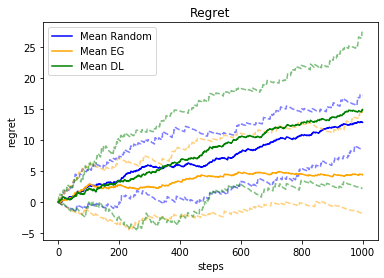

In [75]:
print('Random mean regret: {:.2f}'.format(cum_regretsRandom[:, -1].mean()))
print('EG mean regret: {:.2f}'.format(cum_regretsEG[:, -1].mean()))
print('DL mean regret: {:.2f}'.format(cum_regretsDL[:, -1].mean()))
plt.plot(cum_regretsRandom.mean(axis=0), label='Mean Random', color='blue')
plt.plot(np.quantile(cum_regretsRandom, 0.05, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(np.quantile(cum_regretsRandom, 0.95, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(cum_regretsEG.mean(axis=0), label='Mean EG', color='orange')
plt.plot(np.quantile(cum_regretsEG, 0.05, axis=0), color='orange', ls='--', alpha=0.5)
plt.plot(np.quantile(cum_regretsEG, 0.95, axis=0), color='orange', ls='--', alpha=0.5)
plt.plot(cum_regretsDL.mean(axis=0), label='Mean DL', color='green')
plt.plot(np.quantile(cum_regretsDL, 0.05, axis=0), color='green', ls='--', alpha=0.5)
plt.plot(np.quantile(cum_regretsDL, 0.95, axis=0), color='green', ls='--', alpha=0.5)
plt.xlabel('steps')
plt.ylabel('regret')
plt.legend()
plt.title('Regret')
plt.show()

On 10 tests, EG seems to reliably perform better than random.
DL is horribly bad though.

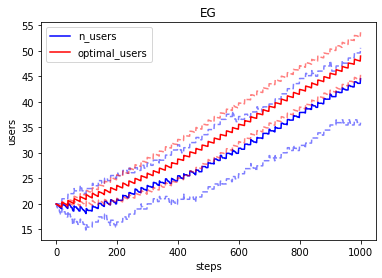

In [79]:
plt.plot(n_usersEG.mean(axis=0), label='n_users', color='blue')
plt.plot(np.quantile(n_usersEG, 0.05, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(np.quantile(n_usersEG, 0.95, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(optimal_usersEG.mean(axis=0), label='optimal_users', color='red')
plt.plot(np.quantile(optimal_usersEG, 0.05, axis=0), color='red', ls='--', alpha=0.5)
plt.plot(np.quantile(optimal_usersEG, 0.95, axis=0), color='red', ls='--', alpha=0.5)
plt.xlabel('steps')
plt.ylabel('users')
plt.legend()
plt.title('EG')
plt.show()

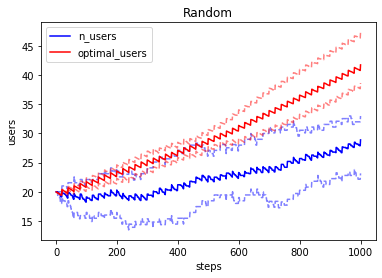

In [80]:
plt.plot(n_usersRandom.mean(axis=0), label='n_users', color='blue')
plt.plot(np.quantile(n_usersRandom, 0.05, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(np.quantile(n_usersRandom, 0.95, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(optimal_usersRandom.mean(axis=0), label='optimal_users', color='red')
plt.plot(np.quantile(optimal_usersRandom, 0.05, axis=0), color='red', ls='--', alpha=0.5)
plt.plot(np.quantile(optimal_usersRandom, 0.95, axis=0), color='red', ls='--', alpha=0.5)
plt.xlabel('steps')
plt.ylabel('users')
plt.legend()
plt.title('Random')
plt.show()

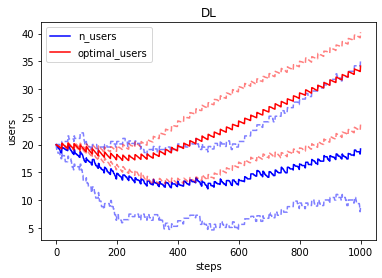

In [81]:
plt.plot(n_usersDL.mean(axis=0), label='n_users', color='blue')
plt.plot(np.quantile(n_usersDL, 0.05, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(np.quantile(n_usersDL, 0.95, axis=0), color='blue', ls='--', alpha=0.5)
plt.plot(optimal_usersDL.mean(axis=0), label='optimal_users', color='red')
plt.plot(np.quantile(optimal_usersDL, 0.05, axis=0), color='red', ls='--', alpha=0.5)
plt.plot(np.quantile(optimal_usersDL, 0.95, axis=0), color='red', ls='--', alpha=0.5)
plt.xlabel('steps')
plt.ylabel('users')
plt.legend()
plt.title('DL')
plt.show()